In [1]:
import copy
import keras
from keras.layers import Activation
from keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Reshape
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import seed, randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

seed(1)

# Učitavanje podataka

In [2]:
# Unos podataka iz csv fajla
data = pd.read_csv('sudoku.csv')

# Igre koje treba resiti = obeležja = features
game_df = data['quizzes']
# Rešene igre = izlazi = targets/labels
solution_df = data['solutions']

# Liste u kojima će se čuvati transformisani podaci
X = []
Y = []

"""
Igra koju treba rešiti je data u formatu 1x81 i treba je transformisati
u oblik koji odgovara ulaznom sloju konvolucione neuralne mreže 9x9x1
"""

for game in game_df:
    X.append(np.array([int(cell) for cell in game]).reshape((9,9,1)))

# Priprema ulaznih podataka = konverzija u ndarray + svodjenje na opseg (-0.5, 0.5)
X = np.array(X)
X = X/9 - 0.5    

# Priprema izlaznih podataka (-1 olaksava kasniju evaluaciju modela i smestanje rezultata u odgovarajuce strukture)
for solution in solution_df:
    Y.append(np.array([int(cell) for cell in solution]).reshape((81,1)) - 1)

# Konverzija u ndarray
Y = np.array(Y)   

# Podela podataka na obučavajući i testirajući skup
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Izdvajanje validacionog skupa podataka (10%)
Nval = X.shape[0]//10
X_val = X_train[-Nval:]
y_val = y_train[-Nval:]
X_train = X_train[:-Nval]
y_train = y_train[:-Nval]

# Prikaz učitanih podataka podataka

In [3]:
example_num = 50
print("Ulaz pre transformacije (0 = prazno polje):")
print(((X_train[example_num,:,:,0]+0.5)*9).astype(int).flatten())
print("\nUlaz nakon transformacije dimenzija:")
print(((X_train[example_num,:,:,0]+0.5)*9).astype(int))
print("\nUlaz nakon transformacije dimenzija i skaliranja na opseg (-0.5,+0.5):")
print(X_train[example_num,:,:,0])
print("\nPrikaz transponovanog izlaza")
print(y_train[example_num].T)

Ulaz pre transformacije (0 = prazno polje):
[0 0 4 3 7 8 0 0 0 0 0 3 0 2 0 7 1 0 9 0 2 4 0 5 0 0 0 0 9 0 0 0 0 2 3 1 2
 5 0 0 0 4 6 0 0 1 0 8 9 6 0 0 0 0 0 0 0 0 0 3 0 4 6 0 6 0 0 0 0 8 9 0 7 0
 1 8 9 0 5 2 0]

Ulaz nakon transformacije dimenzija:
[[0 0 4 3 7 8 0 0 0]
 [0 0 3 0 2 0 7 1 0]
 [9 0 2 4 0 5 0 0 0]
 [0 9 0 0 0 0 2 3 1]
 [2 5 0 0 0 4 6 0 0]
 [1 0 8 9 6 0 0 0 0]
 [0 0 0 0 0 3 0 4 6]
 [0 6 0 0 0 0 8 9 0]
 [7 0 1 8 9 0 5 2 0]]

Ulaz nakon transformacije dimenzija i skaliranja na opseg (-0.5,+0.5):
[[-0.5        -0.5        -0.05555556 -0.16666667  0.27777778  0.38888889
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.16666667 -0.5        -0.27777778 -0.5
   0.27777778 -0.38888889 -0.5       ]
 [ 0.5        -0.5        -0.27777778 -0.05555556 -0.5         0.05555556
  -0.5        -0.5        -0.5       ]
 [-0.5         0.5        -0.5        -0.5        -0.5        -0.5
  -0.27777778 -0.16666667 -0.38888889]
 [-0.27777778  0.05555556 -0.5        -0.5        -0

# Kreiranje modela

In [4]:
# Kreiranje modela
model = keras.models.Sequential()

# Dodavanje konvolucionih slojeva
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(9,9,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(1,1), activation='relu', padding='same'))

# 'Ravnanje' poslednjeg konvolucionog sloja
model.add(Flatten())
# Potpuno povezani sloj
model.add(Dense(81*9))
# Sloj služi kao priprema za izlazni sloj neuralne mreže
model.add(Reshape((-1, 9)))
# Za svako od 81-og polja, vrši se odabir nekog od brojeva 1-9
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 64)          640       
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         8320      
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0         
_________________________________________________________________
dense (Dense)                (None, 729)               7

# Definisanje parametara za obučavanje neuralne mreže

In [5]:
callback = []

# Funkcija za smanjivanje faktora obučavanja
def schedule(epoch, lr):
    return 0.1*lr
callback.append(keras.callbacks.LearningRateScheduler(schedule, verbose=1))

# Rano zaustavljanje
callback.append(keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True))


# Definisanje optimizacione metode i faktora obučavanja
adam = keras.optimizers.Adam(lr=.01)

# Definisanje parametara modela
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=adam,
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Obučavanje neuralne mreže

In [41]:
# Obučavanje modela
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    callbacks=[callback],
                    validation_data=(X_val, y_val),
                    validation_freq=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0009999999776482583.
Epoch 1/10
6250/6250 [==============================] - 1480s 237ms/step - loss: 0.5215 - sparse_categorical_accuracy: 0.7739 - val_loss: 0.3796 - val_sparse_categorical_accuracy: 0.8188

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999310821295e-05.
Epoch 2/10
6250/6250 [==============================] - 1396s 223ms/step - loss: 0.3524 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.3540 - val_sparse_categorical_accuracy: 0.8326

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999019782991e-06.
Epoch 3/10
6250/6250 [==============================] - 1434s 229ms/step - loss: 0.3373 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.3536 - val_sparse_categorical_accuracy: 0.8330

Epoch 00004: LearningRateScheduler reducing learning rate to 9.99999883788405e-07.
Epoch 4/10
6250/6250 [==============================] - 1393s 223ms/step - loss: 0.3357 - sparse_cat

# Čuvanje obučenog modela

In [42]:
model.save('sudokuCNN.h5')

# Učitavanje obučenog modela

In [6]:
model = keras.models.load_model('sudokuCNN.h5')

# Evaluacija modela direktnim rešavanjem

In [7]:
print("Evaluacija modela na testirajucem skupu")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Vrednost loss funkcije, tačnost modela:", results)

Evaluacija modela na testirajucem skupu
3125/3125 [==============================] - 61s 20ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8328
Vrednost loss funkcije, tačnost modela: [0.35395485162734985, 0.8328425884246826]


# Matrica konfuzije

100000/100000 [==============================] - 580s 6ms/step


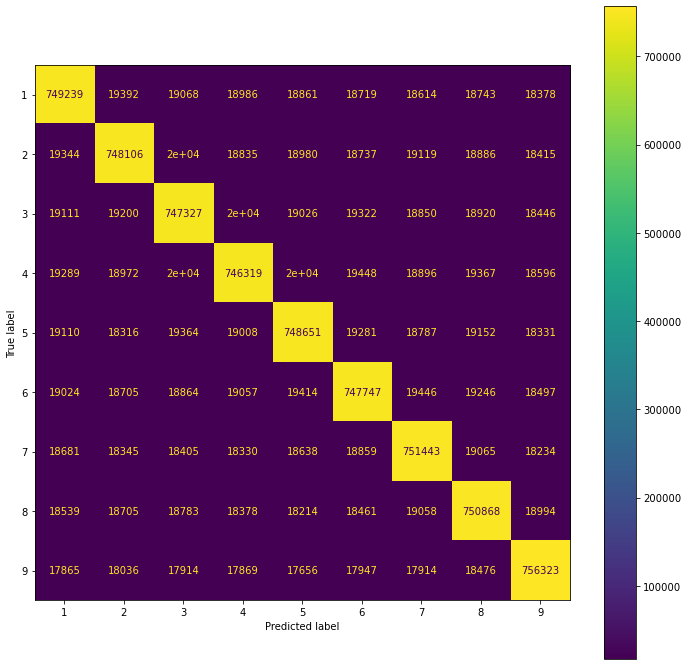

In [8]:
# Predikcija modela na testirajućem skupu
y_pred = np.argmax(model.predict(X_test, batch_size=1, verbose=1), axis=2)

# Izračunavanje matrice konfuzije
cm = confusion_matrix(y_true=y_test.flatten(),
                      y_pred=y_pred.flatten())

# Prikaz matrice konfuzije
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["1", "2", "3", "4", "5", "6", "7", "8", "9"])
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.show()

# Primer direktnog rešavanja

In [9]:
# Biranje nasumičnog indeksa
ind = randint(0, y_test.shape[0]-1)
print("Test primer broj %d" %(ind))

# Direktno rešavanje
y_pred = np.argmax(model.predict(X_test[ind].reshape((1,9,9,1)), batch_size=1, verbose=0), axis=2)

print("============================================")
print("Dobijeni izlaz")
print(y_pred.reshape((9,9))+1)

print("============================================")
print("Stvarni izlaz")
print(y_test[ind].reshape((9,9))+1)

print("Tačnost: %.2f" %(sum(y_pred.flatten()==y_test[ind].flatten())/81))

Test primer broj 17611
Dobijeni izlaz
[[5 9 7 3 6 2 8 4 1]
 [4 2 1 8 9 7 6 3 3]
 [3 8 6 4 2 1 9 4 7]
 [1 6 8 9 7 3 2 5 4]
 [2 5 4 8 8 6 7 9 3]
 [7 3 9 2 4 5 1 6 8]
 [9 1 3 7 5 7 4 8 6]
 [6 7 4 1 1 8 5 1 5]
 [8 4 5 6 3 9 1 7 3]]
Stvarni izlaz
[[5 9 7 3 6 4 8 2 1]
 [4 2 1 8 9 7 6 3 5]
 [3 8 6 5 2 1 9 4 7]
 [1 6 8 9 7 3 2 5 4]
 [2 5 4 1 8 6 7 9 3]
 [7 3 9 2 4 5 1 6 8]
 [9 1 3 7 5 2 4 8 6]
 [6 7 2 4 3 8 5 1 9]
 [8 4 5 6 1 9 3 7 2]]
Tačnost: 0.84


# Funkcija za iterativno rešavanje Sudokua

In [10]:
def predict(model, X, verbose=False):
    
    game = copy.deepcopy(X.reshape((1,9,9,1)))
    
    # Rešenje dobijeno iterativnom procedurom
    """
    Inicijalno je rešenje identično početnoj matrici i popunjava se iterativno.
    Vrednosti matrice se su vraćene na prvobitni oblik (-0.5,+0,5) -> (0, 9),
    nakon čega se umanjuje za jedan zbog poređenja sa već postojećim rešenjima.
    """
    solution = (game.flatten().reshape((81,1))+0.5)*9 - 1

    # Niz polja za koje je rezultat već određen
    used = np.zeros((81,), dtype=bool)
    
    # Zadate vrednosti ne treba estimirati (0/9)-0.5=-0.5
    used = X.flatten() != -0.5
    
    # Iterativno rešavanje
    while(True):
        # Estimacija vrednosti polja zajedno sa verovatnoćama tačnosti odluke
        y_est = model.predict(game).reshape((81,9))

        # Polja koja su već određena se ne uzimaju u razmatranje
        y_est[used] = 0

        # Indeks u matrici sa najvećom verovatnoćom da bude tačan
        ind = np.unravel_index(np.argmax(y_est, axis=None), y_est.shape)

        # Rezultat se pamti u matricu igre
        used[ind[0]] = True

        #  Čuvanje rešenja
        solution[ind[0]] = ind[1]
        
        # Ispis međurezultata
        if(verbose):
            print("-------------------------------------------")
            print("Popunjavanje polja na mestu (%d, %d) brojem %d" %(ind[0]//9+1, ind[0]%9+1, ind[1]+1))
            print(solution.reshape((9,9)).astype(int)+1)
            
        
        # Ukoliko su sva polja popunjena, igra se završava
        if(np.all(used)):
            break
        else:
            # Priprema poslednjeg rešenja za ulaz u neuralnu mrežu
            game = (solution.reshape((1,9,9,1))+1)/9 - 0.5

    return solution.astype(int)

# Iterativno rešavanje na nasumičnom test primeru

In [11]:
# Biranje nasumičnog indeksa
ind = randint(0, y_test.shape[0]-1)
print("Test primer broj %d" %(ind))

# Iterativno rešavanje
sol = predict(model, X_test[ind], verbose=True)

print("============================================")
print("Stvarni izlaz")
print(y_test[ind].reshape((9,9))+1)


Test primer broj 74606
-------------------------------------------
Popunjavanje polja na mestu (3, 2) brojem 1
[[5 2 6 7 0 1 0 4 0]
 [0 0 9 5 0 0 0 0 0]
 [0 1 7 0 4 8 0 6 0]
 [1 0 0 0 0 0 2 3 0]
 [0 6 0 0 9 0 8 0 0]
 [0 3 5 8 0 4 0 0 1]
 [8 0 2 0 0 6 7 0 9]
 [0 0 0 0 0 5 1 0 6]
 [0 0 0 2 7 0 0 0 3]]
-------------------------------------------
Popunjavanje polja na mestu (1, 9) brojem 8
[[5 2 6 7 0 1 0 4 8]
 [0 0 9 5 0 0 0 0 0]
 [0 1 7 0 4 8 0 6 0]
 [1 0 0 0 0 0 2 3 0]
 [0 6 0 0 9 0 8 0 0]
 [0 3 5 8 0 4 0 0 1]
 [8 0 2 0 0 6 7 0 9]
 [0 0 0 0 0 5 1 0 6]
 [0 0 0 2 7 0 0 0 3]]
-------------------------------------------
Popunjavanje polja na mestu (9, 6) brojem 9
[[5 2 6 7 0 1 0 4 8]
 [0 0 9 5 0 0 0 0 0]
 [0 1 7 0 4 8 0 6 0]
 [1 0 0 0 0 0 2 3 0]
 [0 6 0 0 9 0 8 0 0]
 [0 3 5 8 0 4 0 0 1]
 [8 0 2 0 0 6 7 0 9]
 [0 0 0 0 0 5 1 0 6]
 [0 0 0 2 7 9 0 0 3]]
-------------------------------------------
Popunjavanje polja na mestu (3, 1) brojem 3
[[5 2 6 7 0 1 0 4 8]
 [0 0 9 5 0 0 0 0 0]
 [3 1 7 0 4 8

# Evaluacija modela iterativnim rešavanjem

In [12]:
def evaluate(model, X_test, y_test):
    
    # Broj test primera
    N = y_test.shape[0]
    
    # Tačnost modela
    accuracy = []
    
    for i in range(N):
        # Ispis obrađenih uzoraka
        if((i+1) != N):
            print("Test: %d/%d" %(i+1,N), end = "\r")
        else:
            print("Test: %d/%d" %(i+1,N), end = "\n")
        
        # Iterativno rešavanje
        sol = predict(model, X_test[i])
        
        # Dodavanje u listu
        accuracy.append(sum(sol == y_test[i])/81)

    return np.mean(accuracy)

# Nasumični izbor 100 indeksa testirajućeg skupa
ind = []
for _ in range(100):
	ind.append(randint(0, y_test.shape[0]-1))
    
ind.sort()

# Srednja tačnost modela na testirajućem skupu
acc = evaluate(model, X_test[ind], y_test[ind])

print("Srednja tačnost modela na testirajućem skupu jeste: %.2f %%" %(acc*100))

Test: 100/100
Srednja tačnost modela na testirajućem skupu jeste: 100.00 %
